In [ ]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt

In [ ]:
root_dir = './'
torchvision.datasets.MNIST(root=root_dir,download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [ ]:
# Load MNIST dataset
train_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=True)
test_set = torchvision.datasets.MNIST(root=root_dir, download=True, train=False)

In [ ]:
# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

Num. training samples: 60000
Num. test samples:     10000


In [ ]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# extract data and targets
x_train, y_train=train_set.data,train_set.targets
print(x_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [ ]:
# add a dimension to tensor to become B*C*H*W
if len(x_train.shape)==3:
  x_train=x_train.unsqueeze(1)
print(x_train.shape)

torch.Size([60000, 1, 28, 28])


In [ ]:
def show(img):
  # convert tensor to numpy array
  npimg = img.numpy()
  # Convert to H*W*C shape
  npimg_tr=np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr,interpolation='nearest')

torch.Size([3, 152, 242])


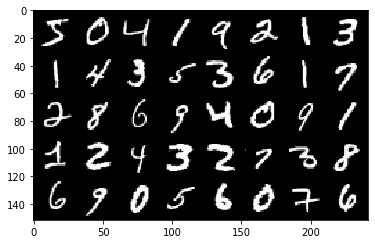

In [ ]:
# make a grid of 40 images, 8 images per row
x_grid=utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)
# call helper function
show(x_grid)

In [ ]:
# List of indexes on the training set
train_idx = list(range(num_train))

# List of indexes of the test set
test_idx = list(range(num_test))

In [ ]:
# Shuffle the training set
import random

random.shuffle(train_idx)
for i in range(10):
  print(train_idx[i])

20562
50873
52291
17799
1256
9460
46271
3776
4336
25640


In [ ]:
# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

54000 samples used as train set
6000  samples used as val set


In [ ]:
len(train_idx)

54000

In [ ]:
from torchvision import transforms

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
])
# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

Re-arrange in even/odd classes

In [ ]:
for i in range(10):
  idx = (train_set.targets==i)
  if (i == 0) or ((i % 2) == 0): train_set.targets[idx] = 0

  else: train_set.targets[idx] = 1

In [ ]:
for i in range(10):
  idx = (test_set.targets==i)
  if (i == 0) or ((i % 2) == 0): test_set.targets[idx] = 0

  else: test_set.targets[idx] = 1

Let's see if it worked

Label: 1


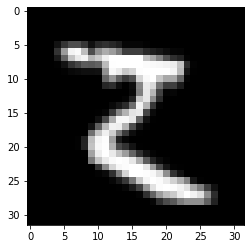

In [ ]:
image, label = train_set[0]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [ ]:
# Split train_dataset into training and validation
from torch.utils.data import Subset

val_set = Subset(train_set, val_idx)
train_set = Subset(train_set, train_idx)

In [ ]:
# Define loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=64, num_workers=2, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=64, num_workers=2, shuffle=False, drop_last=False)


In [ ]:
import torch.nn as nn

class VGG16(nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      # (1(32-1)- 32 + 3)/2 = 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )   

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )   
               

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        return x

In [ ]:
# Create the model
model = VGG16(1)
print(model)

VGG16(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential

In [ ]:
# Get an element from the dataset
test_x, _ = train_set[0] # each element of the dataset is a couple (image, label)

In [ ]:
# Get the size of a sample
test_x.size()

torch.Size([1, 32, 32])

In [ ]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 1, 32, 32])

In [ ]:
test_x.size()

torch.Size([1, 1, 32, 32])

In [ ]:
output = model(test_x)
output.shape

torch.Size([1, 512, 2, 2])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

2048


In [ ]:
class VGG16(nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      # (1(32-1)- 32 + 3)/2 = 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )            

        self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, num_classes) 
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#                 nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    m.bias.detach().zero_()

        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        #logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)
        # probas = nn.Softmax(logits)
        #return probas
        # return logits


In [ ]:
# Create the model
model = VGG16(1)
output = model(test_x)
output.shape

torch.Size([1, 1])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
dev = torch.device('cuda')
print(dev)

cuda


In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=20, dev=dev, save_param = False, model_name="valerio"):
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    labels = labels.unsqueeze(1)
                    labels = labels.float()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    pred_labels = (pred >= 0.5).long() # Binarize predictions to 0 and 1
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

Epoch 1: TrL=0.2592, TrA=0.9359, VL=0.0674, VA=0.9729, TeL=0.0624, TeA=0.9745,
Epoch 2: TrL=0.0642, TrA=0.9773, VL=0.0455, VA=0.9847, TeL=0.0405, TeA=0.9854,
Epoch 3: TrL=0.0447, TrA=0.9841, VL=0.0422, VA=0.9867, TeL=0.0301, TeA=0.9896,
Epoch 4: TrL=0.0348, TrA=0.9883, VL=0.0583, VA=0.9752, TeL=0.0542, TeA=0.9790,
Epoch 5: TrL=0.0279, TrA=0.9901, VL=0.0397, VA=0.9867, TeL=0.0357, TeA=0.9885,
Epoch 6: TrL=0.0237, TrA=0.9915, VL=0.0406, VA=0.9880, TeL=0.0404, TeA=0.9881,
Epoch 7: TrL=0.0183, TrA=0.9938, VL=0.0250, VA=0.9924, TeL=0.0312, TeA=0.9906,
Epoch 8: TrL=0.0174, TrA=0.9940, VL=0.0480, VA=0.9872, TeL=0.0451, TeA=0.9867,
Epoch 9: TrL=0.0137, TrA=0.9953, VL=0.0779, VA=0.9722, TeL=0.0869, TeA=0.9704,
Epoch 10: TrL=0.0121, TrA=0.9959, VL=0.0263, VA=0.9895, TeL=0.0263, TeA=0.9911,


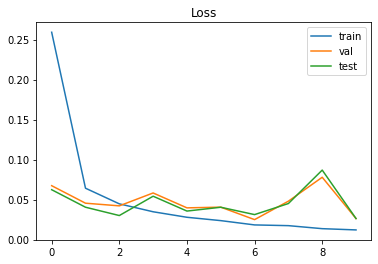

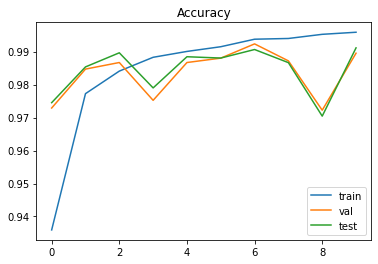

In [ ]:
# Train model
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[[[-7.6350e-01,  5.6528e-01, -2.3996e-01],
           [-6.7057e-01, -3.1837e-01,  1.6944e-02],
           [ 4.5301e-01,  7.7138e-01,  6.0862e-01]]],
 
 
         [[[ 4.4845e-01,  2.3783e-01,  4.9101e-02],
           [ 3.3887e-01, -2.0057e-01,  4.6055e-01],
           [-4.9403e-01,  4.7506e-01, -7.6278e-01]]],
 
 
         [[[ 7.9852e-01,  6.3495e-02,  3.0593e-01],
           [-5.6792e-01, -1.6485e-01,  4.5843e-01],
           [ 6.5533e-01,  5.3739e-01, -4.2833e-01]]],
 
 
         [[[ 2.5185e-01, -3.3722e-02, -7.1280e-01],
           [ 6.0679e-01, -1.6911e-01, -1.9033e-01],
           [ 2.6863e-01,  5.7365e-01, -6.2101e-01]]],
 
 
         [[[ 9.6683e-02, -4.1586e-01,  4.3892e-01],
           [ 2.5974e-01,  1.5350e-01,  4.7868e-01],
           [-7.8461e-01, -3.0047e-01, -7.2888e-01]]],
 
 
         [[[-3.8988e-01,  1.9143e-01, -3.5266e-01],
           [ 1.3965e-02,  3.5640e-01, -7.2734e-01],
           [ 4.4217e-01, -8.0765e-02,  4.2488e-01]]],
 
 
     


----------------------------------------------------------------------------

# SVHN

In [ ]:
base_dir = 'http://ufldl.stanford.edu/housenumbers/'
torchvision.datasets.SVHN(root=base_dir,download=True)

Dataset SVHN
    Number of datapoints: 73257
    Root location: http://ufldl.stanford.edu/housenumbers/
    Split: train

In [ ]:
# Load SVHN dataset
train_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='train', download=True)
test_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='test', download=True)

Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/train_32x32.mat


In [ ]:
# Dataset len
num_train_svhn = len(train_set_svhn)
num_test_svhn = len(test_set_svhn)
print(f"Num. training samples: {num_train_svhn}")
print(f"Num. test samples:     {num_test_svhn}")

Num. training samples: 73257
Num. test samples:     26032


In [ ]:
# extract data and targets
x_train_svhn, y_train_svhn=train_set_svhn.data,train_set_svhn.labels
print(x_train_svhn.shape)
print(y_train_svhn.shape)

(73257, 3, 32, 32)
(73257,)


In [ ]:
# add a dimension to tensor to become B*C*H*W
if len(x_train_svhn.shape)==3:
  x_train_svhn=x_train_svhn.unsqueeze(1)
print(x_train_svhn.shape)

(73257, 3, 32, 32)


In [ ]:
# List of indexes on the training set
train_idx_svhn = list(range(num_train_svhn))

# List of indexes of the test set
test_idx_svhn = list(range(num_test_svhn))

In [ ]:
# Shuffle the training set
import random

random.shuffle(train_idx_svhn)
for i in range(10):
  print(train_idx_svhn[i])

20718
39778
70192
14038
62465
72726
47954
21825
30854
60996


In [ ]:
# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train_svhn * val_frac) 
num_train = num_train_svhn - num_val

# Split training set
val_idx_svhn = train_idx_svhn[num_train:]
train_idx_svhn = train_idx_svhn[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

65932 samples used as train set
7325  samples used as val set


In [ ]:
len(train_idx_svhn)

65932

In [ ]:
from torchvision import transforms

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

# Compose transformations
test_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
])

# Load MNIST dataset with transforms
train_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='train', download=True, transform=data_transform, target_transform=None)
test_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='test', download=True, transform=test_transform)

Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/test_32x32.mat


Re-arrange in even/odd classes

In [ ]:
for i in range(10):
  idx = (train_set_svhn.labels==i)
  if (i == 0) or ((i % 2) == 0): train_set_svhn.labels[idx] = 0

  else: train_set_svhn.labels[idx] = 1

In [ ]:
for i in range(10):
  idx = (test_set_svhn.labels==i)
  if (i == 0) or ((i % 2) == 0): test_set_svhn.labels[idx] = 0

  else: test_set_svhn.labels[idx] = 1

Let's see if it worked

Label: 1


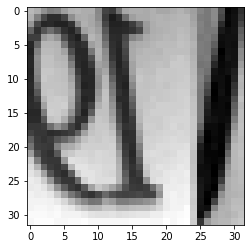

In [ ]:
image, label = train_set_svhn[0]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [ ]:
# Split train_dataset into training and validation
from torch.utils.data import Subset

val_set_svhn = Subset(train_set_svhn, val_idx_svhn)
train_set_svhn = Subset(train_set_svhn, train_idx_svhn)

In [ ]:
# Define loaders
from torch.utils.data import DataLoader
train_loader_svhn = DataLoader(train_set_svhn, batch_size=64, num_workers=2, shuffle=True, drop_last=True)
val_loader_svhn   = DataLoader(val_set_svhn,   batch_size=64, num_workers=2, shuffle=False, drop_last=False)
test_loader_svhn  = DataLoader(test_set_svhn,  batch_size=64, num_workers=2, shuffle=False, drop_last=False)


Celle da eliminare:

In [ ]:
def show(image):
  ig, axes = plt.subplots()
  plt.imshow(image)

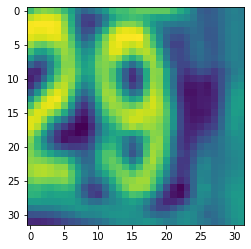

In [ ]:
dataiter = iter(train_loader_svhn)
images, labels = dataiter.next()
for i in range(0,1):
  img = images[i]
  img = img.numpy().squeeze()
  show(img)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

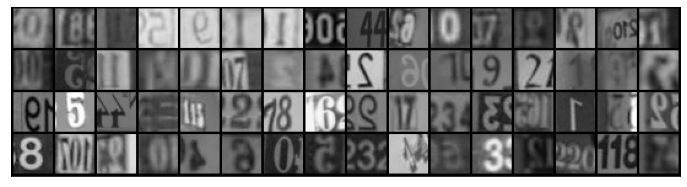

In [ ]:
show_batch(train_loader_svhn)

In [ ]:
import torch.nn as nn

class VGG16(nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      # (1(32-1)- 32 + 3)/2 = 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        ) 
                   

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        return x

In [ ]:
# Create the model
model1 = VGG16(10)
print(model1)

VGG16(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential

In [ ]:
# Get an element from the dataset
test_x, _ = train_set_svhn[0] # each element of the dataset is a couple (image, label)

In [ ]:
# Get the size of a sample
test_x.size()

torch.Size([1, 32, 32])

In [ ]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 1, 32, 32])

In [ ]:
test_x.size()

torch.Size([1, 1, 32, 32])

In [ ]:
output = model1(test_x)
output.shape

torch.Size([1, 512, 2, 2])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

2048


In [ ]:
class VGG16(nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      # (1(32-1)- 32 + 3)/2 = 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        ) 


        self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, num_classes),
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#                 nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    m.bias.detach().zero_()

        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        #logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)
        # probas = nn.Softmax(logits)
        #return probas
        # return logits


In [ ]:
# Create the model
model1 = VGG16(1)
output = model1(test_x)
output.shape

torch.Size([1, 1])

In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model1.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Define dictionary of loaders
loaders_svhn = {"train": train_loader_svhn,
           "val": val_loader_svhn,
           "test": test_loader_svhn}

Epoch 1: TrL=0.6857, TrA=0.6220, VL=0.4756, VA=0.7401, TeL=0.4789, TeA=0.7418,
Epoch 2: TrL=0.4189, TrA=0.7933, VL=0.3503, VA=0.8238, TeL=0.3560, TeA=0.8282,
Epoch 3: TrL=0.3139, TrA=0.8547, VL=0.2910, VA=0.8783, TeL=0.3240, TeA=0.8667,
Epoch 4: TrL=0.2501, TrA=0.8879, VL=0.2389, VA=0.8926, TeL=0.2605, TeA=0.8835,
Epoch 5: TrL=0.2060, TrA=0.9096, VL=0.2146, VA=0.9085, TeL=0.2315, TeA=0.9050,
Epoch 6: TrL=0.1721, TrA=0.9258, VL=0.2141, VA=0.9044, TeL=0.2367, TeA=0.8963,
Epoch 7: TrL=0.1507, TrA=0.9356, VL=0.1986, VA=0.9150, TeL=0.2217, TeA=0.9031,
Epoch 8: TrL=0.1299, TrA=0.9450, VL=0.1991, VA=0.9245, TeL=0.2142, TeA=0.9207,
Epoch 9: TrL=0.1103, TrA=0.9548, VL=0.2093, VA=0.9192, TeL=0.2237, TeA=0.9143,
Epoch 10: TrL=0.0988, TrA=0.9597, VL=0.2021, VA=0.9166, TeL=0.2244, TeA=0.9091,


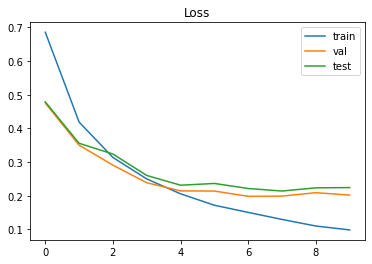

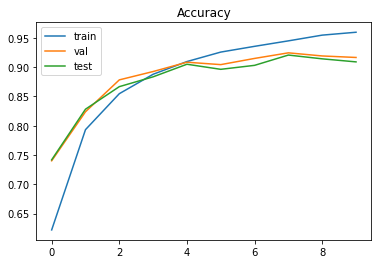

In [ ]:
# Train model
train(model1, loaders_svhn, optimizer, criterion, epochs=10, dev=dev)

In [ ]:
list(model1.parameters())

[Parameter containing:
 tensor([[[[ 0.5388,  0.6938,  0.3826],
           [-0.7382,  0.6381,  0.4537],
           [-0.2710, -0.5323, -0.7753]]],
 
 
         [[[-0.1726, -0.3722, -0.7197],
           [ 0.8005,  0.0232, -0.0926],
           [-0.4586, -0.5571,  0.3452]]],
 
 
         [[[-0.3000, -0.5278, -0.2463],
           [-0.4286, -0.7807, -0.2645],
           [ 0.0072, -0.3657, -0.6306]]],
 
 
         [[[ 0.6303,  0.6237,  0.1176],
           [ 0.4696,  0.4867, -0.6742],
           [ 0.0459,  0.6756, -0.7905]]],
 
 
         [[[-0.4358, -0.5120, -0.0178],
           [-0.4295, -0.6153, -0.0538],
           [-0.3474,  0.1851,  0.4839]]],
 
 
         [[[-0.7418,  0.7699,  0.1940],
           [ 0.5494,  0.8108,  0.4925],
           [ 0.2746,  0.1525,  0.7891]]],
 
 
         [[[-0.2819,  0.5883, -0.3917],
           [-0.1557,  0.0843, -0.0999],
           [-0.7280, -0.1807, -0.1590]]],
 
 
         [[[-0.5928, -0.4524, -0.3422],
           [-0.1767, -0.0174, -0.6672],
           [ 0.

----------------------------------------------------------------------

# MERGED MODELS

In [ ]:
class VGG16SUM(nn.Module):
    
    def __init__(self, model1, model2, num_classes):
        super(VGG16SUM, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      # (1(32-1)- 32 + 3)/2 = 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        ) 


        self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, num_classes),
        )

        for p_out, p_in1, p_in2 in zip(self.parameters(), model1.parameters(), model2.parameters()):
            p_out.data = nn.Parameter(p_in1 +p_in2);

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        #logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)
        # probas = nn.Softmax(logits)
        #return probas
        # return logits

In [ ]:
modelsum = VGG16SUM(model, model1, 1).cuda()
print(modelsum)

VGG16SUM(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequent

In [ ]:
list(modelsum.parameters())

[Parameter containing:
 tensor([[[[-2.2472e-01,  1.2590e+00,  1.4266e-01],
           [-1.4088e+00,  3.1971e-01,  4.7067e-01],
           [ 1.8202e-01,  2.3908e-01, -1.6669e-01]]],
 
 
         [[[ 2.7581e-01, -1.3435e-01, -6.7060e-01],
           [ 1.1394e+00, -1.7739e-01,  3.6792e-01],
           [-9.5267e-01, -8.2044e-02, -4.1762e-01]]],
 
 
         [[[ 4.9856e-01, -4.6435e-01,  5.9649e-02],
           [-9.9655e-01, -9.4554e-01,  1.9390e-01],
           [ 6.6257e-01,  1.7172e-01, -1.0589e+00]]],
 
 
         [[[ 8.8217e-01,  5.8999e-01, -5.9519e-01],
           [ 1.0764e+00,  3.1760e-01, -8.6451e-01],
           [ 3.1453e-01,  1.2492e+00, -1.4116e+00]]],
 
 
         [[[-3.3907e-01, -9.2785e-01,  4.2114e-01],
           [-1.6981e-01, -4.6185e-01,  4.2484e-01],
           [-1.1320e+00, -1.1535e-01, -2.4502e-01]]],
 
 
         [[[-1.1317e+00,  9.6130e-01, -1.5866e-01],
           [ 5.6336e-01,  1.1672e+00, -2.3484e-01],
           [ 7.1672e-01,  7.1776e-02,  1.2140e+00]]],
 
 
     

In [ ]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            preds = model(data_inputs.cuda())
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels.cuda()).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print("Accuracy of the model: %4.2f%%" % (100.0*acc))

In [ ]:
eval_model(modelsum, test_loader)

Accuracy of the model: 49.26%


In [ ]:
eval_model(modelsum, test_loader_svhn)

Accuracy of the model: 46.30%


In [ ]:
class VGG16MAX(nn.Module):
    
    def __init__(self, model1, model2, num_classes):
        super(VGG16MAX, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      # (1(32-1)- 32 + 3)/2 = 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        ) 


        self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.25),
            nn.Linear(4096, num_classes),
        )

        for p_out, p_in1, p_in2 in zip(self.parameters(), model1.parameters(), model2.parameters()):
            p_out.data = nn.Parameter(torch.max(p_in1, p_in2));

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        #logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)
        # probas = nn.Softmax(logits)
        #return probas
        # return logits

In [ ]:
modelmax = VGG16MAX(model, model1, 1).cuda()
print(modelmax)

VGG16MAX(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequent

In [ ]:
list(modelmax.parameters())

[Parameter containing:
 tensor([[[[ 5.3879e-01,  6.9375e-01,  3.8262e-01],
           [-6.7057e-01,  6.3808e-01,  4.5373e-01],
           [ 4.5301e-01,  7.7138e-01,  6.0862e-01]]],
 
 
         [[[ 4.4845e-01,  2.3783e-01,  4.9101e-02],
           [ 8.0051e-01,  2.3181e-02,  4.6055e-01],
           [-4.5864e-01,  4.7506e-01,  3.4516e-01]]],
 
 
         [[[ 7.9852e-01,  6.3495e-02,  3.0593e-01],
           [-4.2863e-01, -1.6485e-01,  4.5843e-01],
           [ 6.5533e-01,  5.3739e-01, -4.2833e-01]]],
 
 
         [[[ 6.3032e-01,  6.2371e-01,  1.1761e-01],
           [ 6.0679e-01,  4.8671e-01, -1.9033e-01],
           [ 2.6863e-01,  6.7558e-01, -6.2101e-01]]],
 
 
         [[[ 9.6683e-02, -4.1586e-01,  4.3892e-01],
           [ 2.5974e-01,  1.5350e-01,  4.7868e-01],
           [-3.4743e-01,  1.8512e-01,  4.8386e-01]]],
 
 
         [[[-3.8988e-01,  7.6987e-01,  1.9401e-01],
           [ 5.4940e-01,  8.1080e-01,  4.9250e-01],
           [ 4.4217e-01,  1.5254e-01,  7.8908e-01]]],
 
 
     

In [ ]:
eval_model(modelmax, test_loader)

Accuracy of the model: 50.74%


In [ ]:
eval_model(modelmax, test_loader_svhn)

Accuracy of the model: 53.70%


----------------------------------------------------------------------

# TRAIN THE CLASSIFIER

In [ ]:
modelsum_classifier = VGG16SUM(model, model1, 1).cuda()
print(modelsum_classifier)

VGG16SUM(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequent

In [ ]:
# First, we set require_grad = False for all the layer of the net
for param in modelsum_classifier.parameters():
  param.requires_grad = False

In [ ]:
# Then, we replace the classification layers with a new final fully connectect layer
modelsum_classifier.classifier[0] = torch.nn.Linear(in_features=2048, out_features = 4096)
modelsum_classifier.classifier[3] = torch.nn.Linear(in_features=4096, out_features = 4096)
modelsum_classifier.classifier[6] = torch.nn.Linear(in_features=4096, out_features = 1)

Train only the classifier, one for each dataset

Epoch 1: TrL=0.7019, TrA=0.4911, VL=0.6959, VA=0.4888, TeL=0.7016, TeA=0.4926,
Epoch 2: TrL=0.7023, TrA=0.4906, VL=0.6964, VA=0.4888, TeL=0.7018, TeA=0.4926,


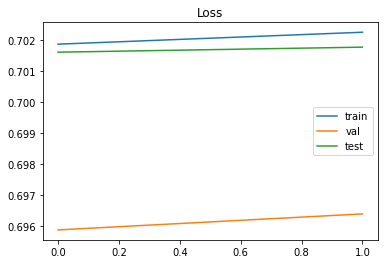

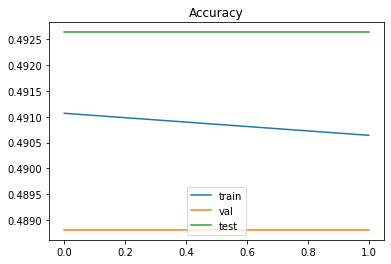

In [ ]:
# Train model
train(modelsum_classifier, loaders, optimizer, criterion, epochs=2, dev=dev)

In [ ]:
modelsum_classifier_svhn = VGG16SUM(model, model1, 1).cuda()

In [ ]:
# First, we set require_grad = False for all the layer of the net
for param in modelsum_classifier_svhn.parameters():
  param.requires_grad = False

In [ ]:
# Then, we replace the classification layers with a new final fully connectect layer
modelsum_classifier_svhn.classifier[0] = torch.nn.Linear(in_features=2048, out_features = 4096)
modelsum_classifier_svhn.classifier[3] = torch.nn.Linear(in_features=4096, out_features = 4096)
modelsum_classifier_svhn.classifier[6] = torch.nn.Linear(in_features=4096, out_features = 1)

Epoch 1: TrL=0.6967, TrA=0.4661, VL=0.6927, VA=0.4655, TeL=0.6929, TeA=0.4635,
Epoch 2: TrL=0.6977, TrA=0.4647, VL=0.6928, VA=0.4643, TeL=0.6930, TeA=0.4637,


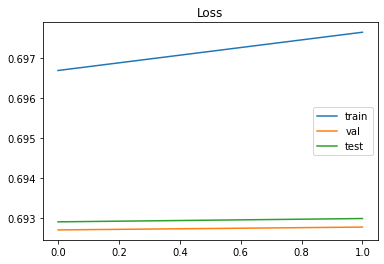

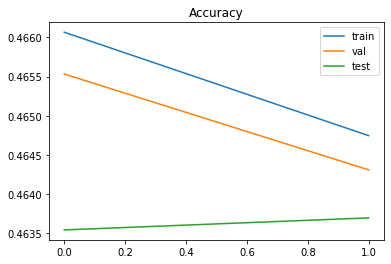

In [ ]:
# Train model
train(modelsum_classifier_svhn, loaders_svhn, optimizer, criterion, epochs=2, dev=dev)

Now the max

In [ ]:
modelmax_classifier = VGG16MAX(model, model1, 1).cuda()

In [ ]:
# First, we set require_grad = False for all the layer of the net
for param in modelmax_classifier.parameters():
  param.requires_grad = False

In [ ]:
# Then, we replace the classification layers with a new final fully connectect layer
modelmax_classifier.classifier[0] = torch.nn.Linear(in_features=2048, out_features = 4096)
modelmax_classifier.classifier[3] = torch.nn.Linear(in_features=4096, out_features = 4096)
modelmax_classifier.classifier[6] = torch.nn.Linear(in_features=4096, out_features = 1)

Epoch 1: TrL=0.6793, TrA=0.4919, VL=0.6774, VA=0.4888, TeL=0.6767, TeA=0.4926,
Epoch 2: TrL=0.6786, TrA=0.4918, VL=0.6763, VA=0.4888, TeL=0.6760, TeA=0.4926,


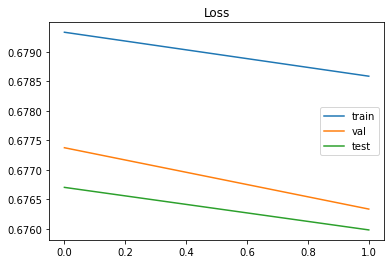

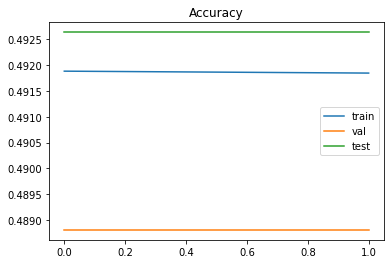

In [ ]:
# Train model
train(modelmax_classifier, loaders, optimizer, criterion, epochs=2, dev=dev)

In [ ]:
modelmax_classifier_svhn = VGG16MAX(model, model1, 1).cuda()

In [ ]:
# First, we set require_grad = False for all the layer of the net
for param in modelmax_classifier_svhn.parameters():
  param.requires_grad = False

In [ ]:
# Then, we replace the classification layers with a new final fully connectect layer
modelmax_classifier_svhn.classifier[0] = torch.nn.Linear(in_features=2048, out_features = 4096)
modelmax_classifier_svhn.classifier[3] = torch.nn.Linear(in_features=4096, out_features = 4096)
modelmax_classifier_svhn.classifier[6] = torch.nn.Linear(in_features=4096, out_features = 1)

Epoch 1: TrL=0.7031, TrA=0.4642, VL=0.7009, VA=0.4660, TeL=0.7042, TeA=0.4694,
Epoch 2: TrL=0.7026, TrA=0.4653, VL=0.6999, VA=0.4650, TeL=0.7027, TeA=0.4691,


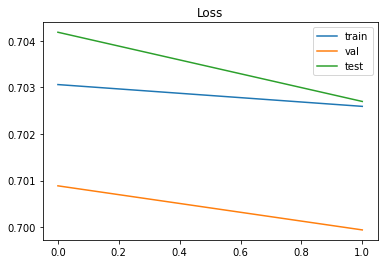

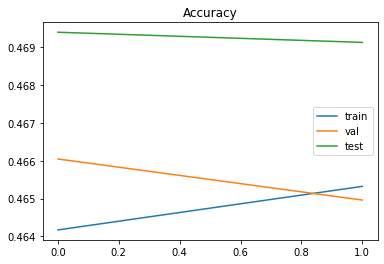

In [ ]:
# Train model
train(modelmax_classifier_svhn, loaders_svhn, optimizer, criterion, epochs=2, dev=dev)